### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mne
import arff

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

%load_ext autoreload
%autoreload 2

### eyes open/eyes closed on EEG Motor Movement/Imagery Dataset

- EEG Motor Movement датасет состоит из 109 испытуемых
- Данные каждого испытуемого состоят из 14 выполненных тестов
- Мы сейчас сосредоточимся за заданиях 1 и 2 с классификацией открытых/закрытых глаз
- Задание 1 $-$ бег с открытыми глазами
- Задание 2 $-$ бег с закрытыми глазами

Subject_1

- Число каналов 64
- Размер выборки 9760
- Частота измерений 160 $c^{-1}$

In [14]:
# Получение данных первого испытуемого во время пробежки с открытыми глазами
sub_1_path = os.path.join(os.path.dirname(os.getcwd()), 'code', 'eeg-motor-movementimagery-dataset', 'files', 'S001', 'S001R01.edf') 
sub_1 = mne.io.read_raw_edf(sub_1_path, preload=True)

Extracting EDF parameters from c:\Users\Чёрный господин\Documents\GitHub\project_VKR\code\eeg-motor-movementimagery-dataset\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [15]:
X_sub_1 = sub_1.get_data()

In [16]:
X_sub_1.shape

(64, 9760)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


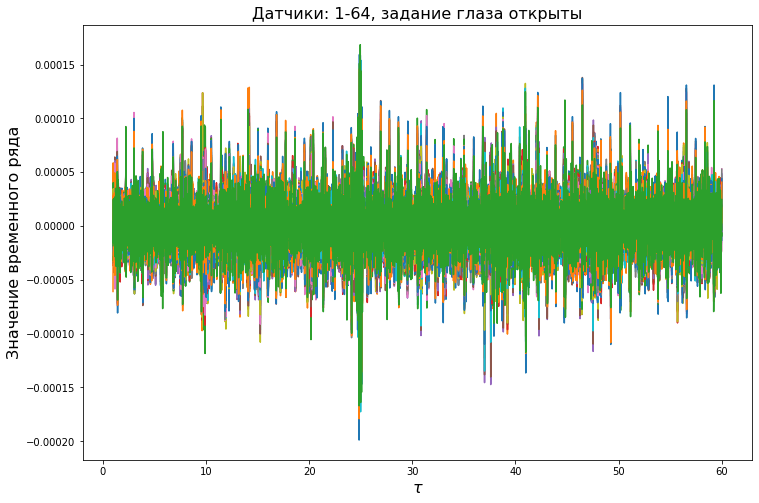

In [17]:
sfreq = sub_1.info['sfreq']
sfreq = sub_1.info['sfreq']
sub_1.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

data, times = sub_1[:-1,int(sfreq * 1):int(sfreq * 60)]

fig = plt.subplots(figsize = (12,8))
plt.plot(times, data.T)
plt.xlabel(r'$\tau$', fontsize=16)
plt.ylabel('Значение временного ряда', fontsize=16)
plt.title('Датчики: 1-64, задание глаза открыты', fontsize=16)
#plt.legend(sub_1.ch_names)
plt.savefig('Dataset_1_eyes_open.pdf')


### Датасет EEG Eye State из UCI

Все данные получены в результате одного непрерывного измерения ЭЭГ с помощью нейроголовки Emotiv EEG. Продолжительность измерения составила 117 секунд. Состояние глаз было зафиксировано с помощью камеры во время измерения ЭЭГ и позже добавлено вручную в файл после анализа видеокадров. Метка класса 1 указывает на состояние с закрытыми глазами, а метка 0 - на состояние с открытыми глазами. Все значения приведены в хронологическом порядке с первым измеренным значением в верхней части данных.

Характеристики соответствуют 14 измерениям ЭЭГ с помощью гарнитуры, первоначально обозначенным как AF 3, F7, F3, FC5, T7, P, O1, O2, P8, T8, FC6, F4, F8, AF4

### Загрузка датасета

In [149]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'code', 'dataset_eeg_eye_state', 'EEGEyeState.arff') 

# Открываем .arff файл и загружаем данные
with open(data_path, 'r', encoding='utf-8') as file:
    data = arff.load(file)

# Преобразуем данные в DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
# датасет в numpy
time_columns = df.columns[:14]
X = np.array(df[time_columns])
y = df['eyeDetection'].to_numpy(int)

df['eyeDetection'] = y

### Анализ датасета

In [150]:
df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [151]:
df.shape

(14980, 15)

Частота измерений есть 128.0342 Гц

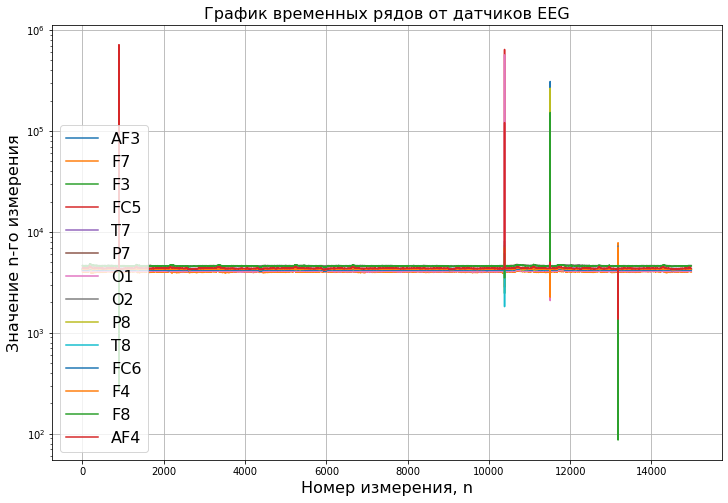

In [152]:
plt.figure(figsize=(12, 8))
plt.title("График временных рядов от датчиков EEG", fontsize=16)
plt.xlabel("Номер измерения, n", fontsize=16)
plt.ylabel("Значение n-го измерения", fontsize=16)
plt.yscale('log')
plt.grid(0.1)
# Отображение каждого временного ряда с названием столбца
for i, col in enumerate(time_columns):
    plt.plot(np.arange(0, 14980), df[col], label=col)

plt.legend(fontsize=16)
plt.show()

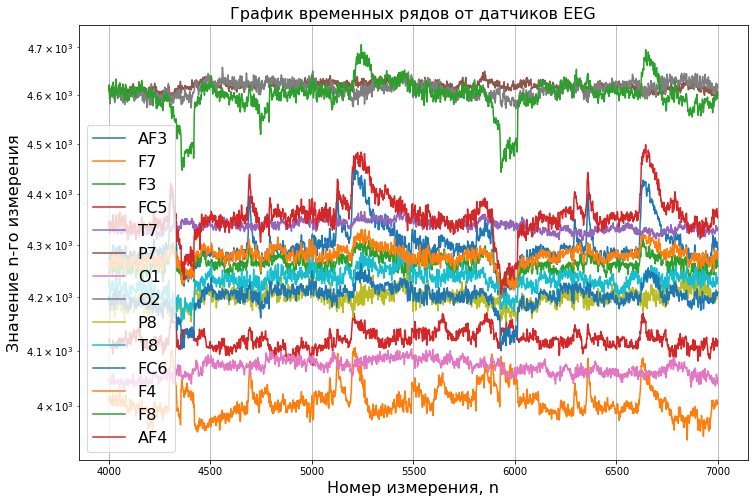

In [153]:
plt.figure(figsize=(12, 8))
plt.title("График временных рядов от датчиков EEG", fontsize=16)
plt.xlabel("Номер измерения, n", fontsize=16)
plt.ylabel("Значение n-го измерения", fontsize=16)
plt.yscale('log')
plt.grid(0.1)
# Отображение каждого временного ряда с названием столбца
for i, col in enumerate(time_columns):
    plt.plot(np.arange(4000, 7000), df[col][4000:7000], label=col)

plt.legend(fontsize=16)
plt.show()

Из первого графика видно, что имеются выбросы

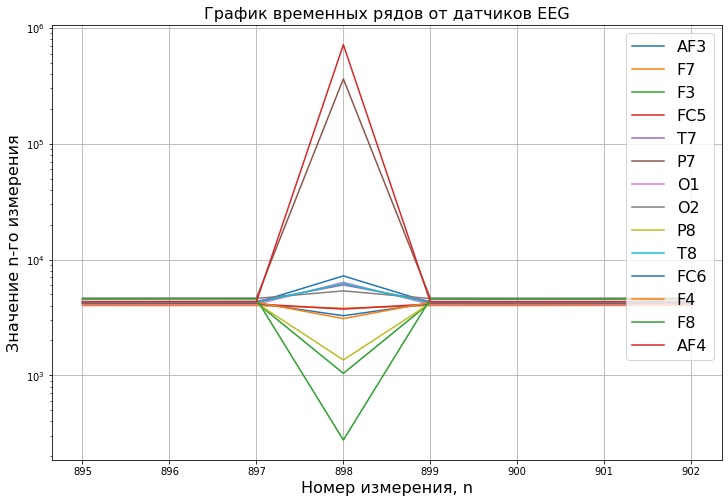

In [154]:
plt.figure(figsize=(12, 8))
plt.title("График временных рядов от датчиков EEG", fontsize=16)
plt.xlabel("Номер измерения, n", fontsize=16)
plt.ylabel("Значение n-го измерения", fontsize=16)
plt.yscale('log')
plt.grid(0.1)
# Отображение каждого временного ряда с названием столбца
for i, col in enumerate(time_columns):
    plt.plot(np.arange(895, 903), df[col][895:903], label=col)

plt.legend(fontsize=16)
plt.show()

Рассмотрим один из датчиков, отрисуем график, на котором одним цветом будут отображены моменты закрытых глаз, другим открытых.

In [155]:
X_AF3 = X.T[0]
X_AF3.shape

(14980,)

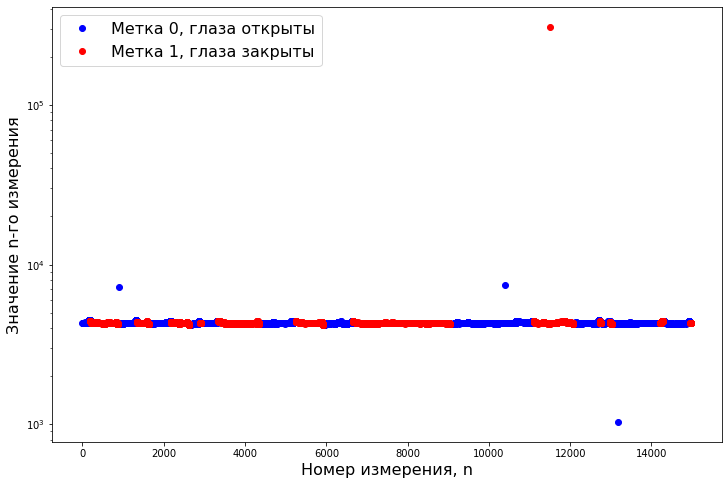

In [156]:
# Разделение временного ряда на два списка по меткам

X_AF3_0 = [X_AF3[i] for i, label in enumerate(y) if label == 0]
X_AF3_1 = [X_AF3[i] for i, label in enumerate(y) if label == 1]

n = np.arange(X_AF3.shape[0])
n_0 = [n[i] for i, label in enumerate(y) if label == 0]
n_1 = [n[i] for i, label in enumerate(y) if label == 1]

# Построение графика
plt.figure(figsize=(12, 8))

plt.plot(n_0, X_AF3_0, 'bo', label='Метка 0, глаза открыты')  
plt.plot(n_1, X_AF3_1, 'ro', label='Метка 1, глаза закрыты')  
plt.xlabel("Номер измерения, n", fontsize=16)
plt.ylabel("Значение n-го измерения", fontsize=16)
plt.yscale('log')
plt.legend(fontsize=16)

Предобработаем выбросы, заменим значения, которые выходят за 3 сигма средними по классам

In [170]:
# Вычисляем среднее значение по классам
class_mean = df.groupby('eyeDetection').mean()
    
# Вычисляем стандартное отклонение по классам
class_std = df.groupby('eyeDetection').std()

mean = df[time_columns].mean().values
std = df[time_columns].std().values

In [191]:
Emission_numbers = []
for i in range(X_AF3.shape[0]):
    if np.abs(X_AF3[i]-mean[0]) > 1e3:
        Emission_numbers.append(i)

In [192]:
Emission_numbers

[898, 10386, 11509, 13179]

In [208]:
df_preprocessed = df.copy()

for row_index in Emission_numbers:
    df_preprocessed.loc[row_index, :df.columns[-2]] = class_mean.loc[y[row_index]].values

X_preprocessed = np.array(df_preprocessed[time_columns])
y = df['eyeDetection'].to_numpy(int)

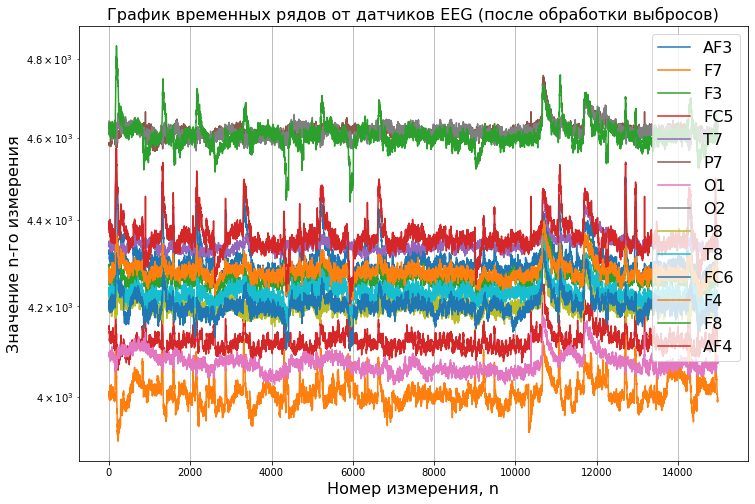

In [258]:
plt.figure(figsize=(12, 8))
plt.title("График временных рядов от датчиков EEG (после обработки выбросов)", fontsize=16)
plt.xlabel("Номер измерения, n", fontsize=16)
plt.ylabel("Значение n-го измерения", fontsize=16)
plt.yscale('log')
plt.grid(0.1)
# Отображение каждого временного ряда с названием столбца
for i, col in enumerate(time_columns):
    plt.plot(np.arange(0, 14980), df_preprocessed[col], label=col)

plt.legend(fontsize=16)
plt.savefig('Dataset.pdf')
plt.show()

### Распределения значений временных рядов

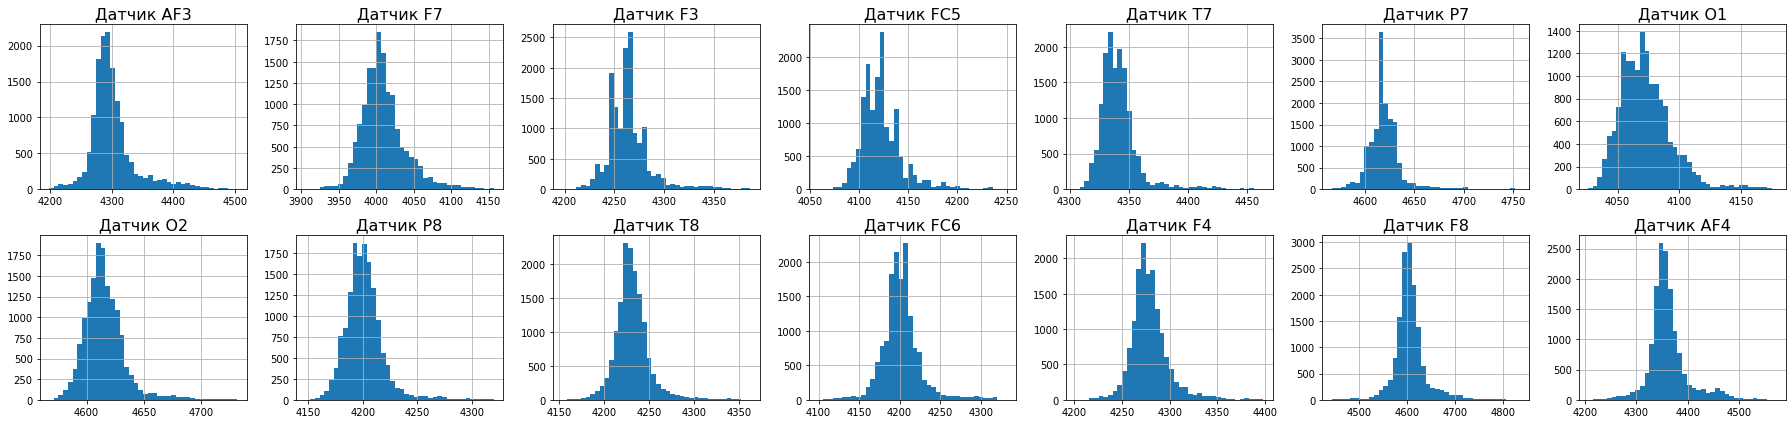

In [222]:
fig, ax = plt.subplots(2, 7, figsize=(25, 6))

for num, col in enumerate(time_columns):
    i = num // 7
    j = num % 7
    df_preprocessed[col].hist(bins=40, ax=ax[i, j])
    ax[i, j].set_title(f"Датчик {col}", fontsize = 16)

plt.tight_layout()
plt.show()

## Базовые модели классификации

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, shuffle=False)

In [240]:
print(f'метка 0: {y_train[y_train==0].shape[0]}, метка 1: {y_train[y_train==1].shape[0]}')

метка 0: 4922, метка 1: 5564


In [242]:
print(f'метка 0: {y_test[y_test==0].shape[0]}, метка 1: {y_test[y_test==1].shape[0]}')

метка 0: 3335, метка 1: 1159


### KNeighborsClassifier

In [246]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

c:\phyton\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [247]:
print('Test Accuracy: {}'.format(accuracy_score(y_test, y_pred_knn)))
print('Test f1-score weighted: {}'.format(f1_score(y_test, y_pred_knn, average='weighted')))

Test Accuracy: 0.5222518914107699
Test f1-score weighted: 0.5500283105261136


### SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1e-1, 1, 1e1]
}

gscv = GridSearchCV(svm, param_grid, scoring='accuracy', n_jobs=-1)
gscv.fit(X_train, y_train)

print(f'SVM best score: {gscv.best_score_}')
print(f'SVM best params: {gscv.best_params_}')

In [256]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

In [257]:
print('Test Accuracy: {}'.format(accuracy_score(y_test, y_pred_svm)))
print('Test f1-score weighted: {}'.format(f1_score(y_test, y_pred_svm, average='weighted')))

Test Accuracy: 0.289942145082332
Test f1-score weighted: 0.20960126914053706


In [ ]:
from models import EEGNet
from fitting import train

if torch.cuda.is_available():
    target_device = 'cuda'
else:
    target_device = 'cpu'
    
model = EEGNet().to(target_device)